In [1]:
from model import FFNet
from learning import Learn, Selector
from dataset import Dummy

from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

<class 'dataset.Dummy'> dataset created...
epoch: 0 of 100, train loss: 9560.586555727066, val loss: 1201.5140787760417, lr: 0.01
epoch: 10 of 100, train loss: 803.9006948163433, val loss: 594.1117960611979, lr: 0.01
epoch: 20 of 100, train loss: 736.534891436177, val loss: 699.5752563476562, lr: 0.01
epoch: 30 of 100, train loss: 520.7937307050152, val loss: 692.478769938151, lr: 0.001
epoch: 40 of 100, train loss: 531.2818795481036, val loss: 518.0540364583334, lr: 0.001
epoch: 50 of 100, train loss: 532.2423381190146, val loss: 498.88140869140625, lr: 0.0001
epoch: 60 of 100, train loss: 573.2740370227444, val loss: 714.0433349609375, lr: 0.0001
epoch: 70 of 100, train loss: 604.667463733304, val loss: 559.734608968099, lr: 1e-05
epoch: 80 of 100, train loss: 524.1947188838835, val loss: 498.4258524576823, lr: 1.0000000000000002e-06
epoch: 90 of 100, train loss: 560.6248168945312, val loss: 630.188710530599, lr: 1.0000000000000002e-07
test loss: 422.0671691894531
y_pred:
tensor([[-2

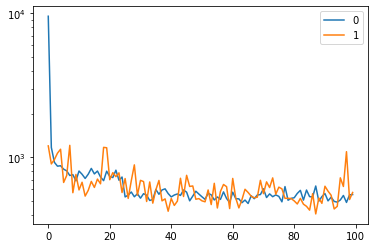

learning time: 0:00:56.637895


In [2]:
opt_params = {'lr': 0.01}
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10}

l = Learn(Dummy, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=100)